First:
- go to the terminal
- go to the `4_tuning_networks` folder, use `cd` to get there, or `z` to get there faster.
- if you are planning on closing the laptop to let this run by itself, start a tmux session by giving the command `tmux`. You can name the session with `ctrl+b $`, leave the tmux with `ctrl+b` d, access it again with `tmux a -t 0` or replace the 0 with the name you gave it. See [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) for more info.
- Activate the `.venv`, and run `python hypertune.py`
- In the hypertune.py file, a tune_dir is specified: `models/ray`. We will check the contents of that folder after the hypertune finished. You can also use tensorboard to check the results. 
- this will take some time. I clocked 1901 seconds (30 minutes) on the VM

 0.0992908 |           119 |            3 |     26 |         576.744  |    0 |   0.942187

In [41]:
from pathlib import Path

tune_dir = Path("../models/ray").resolve()
tune_dir.exists()

True

In [42]:
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
latest = tunelogs[-4]
latest

PosixPath('/home/azureuser/code/mads-exam-24/models/ray/train_2024-07-05_07-09-22')

In [43]:
from ray.tune import ExperimentAnalysis
import ray

ray.init(ignore_reinit_error=True)


analysis = ExperimentAnalysis(latest)

2024-07-06 10:07:05,722	INFO worker.py:1558 -- Calling ray.init() again after it has already been called.
2024-07-06 10:07:05,820	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 1 trial(s):
- train_b39ecd64: FileNotFoundError('Could not fetch metrics for train_b39ecd64: both result.json and progress.csv were not found at /home/azureuser/code/mads-exam-24/models/ray/train_2024-07-05_07-09-22/train_b39ecd64_47_data_dir=ref_ph_5a725494,dropout=0.1794,hidden=81,num_blocks=2,num_heads=1,output=5,tune_dir=ref_ph_b1421250_2024-07-05_13-30-08')


So, we find some info:

In [44]:
analysis.results_df.columns

Index(['iterations', 'train_loss', 'test_loss', 'Recallmacro', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/hidden', 'config/num_heads', 'config/dropout', 'config/output',
       'config/num_blocks', 'config/tune_dir', 'config/data_dir'],
      dtype='object')

Let's focus on the parameters we wanted to tune.

In [45]:
import plotly.express as px

plot = analysis.results_df
select = [
    "Recallmacro",
    "config/hidden",
    "config/num_blocks",
    "config/dropout",
    "train_loss",
    "test_loss",
]
p = plot[select].reset_index().dropna()

Let's sort by Recall

In [46]:
p.sort_values("Recallmacro", inplace=True)

Make a parallel plot

In [47]:
px.parallel_coordinates(p, color="Recallmacro")

<Axes: xlabel='config/hidden', ylabel='config/num_blocks'>

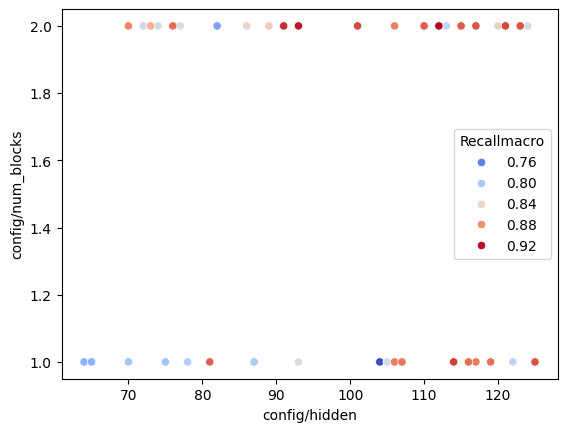

In [48]:
import seaborn as sns

sns.scatterplot(
    data=p, x="config/hidden", y="config/num_blocks", hue="Recallmacro", palette="coolwarm"
)

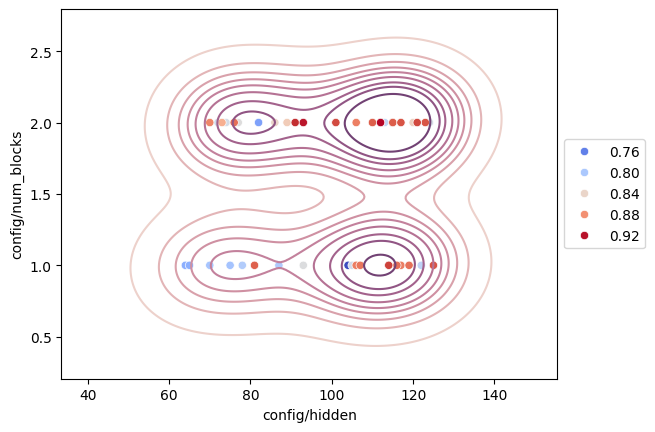

In [49]:
import matplotlib.pyplot as plt

cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(
    data=p, x="config/hidden", y="config/num_blocks", hue="Recallmacro", palette="coolwarm"
)
sns.kdeplot(data=p, x="config/hidden", y="config/num_blocks", cmap=cmap)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)

Get the best trial

In [50]:
analysis.get_best_trial(metric="test_loss", mode="min")

train_4d1aaba3

The top ten

In [51]:
p[-10:]

,trial_id,Recallmacro,config/hidden,config/num_blocks,config/dropout,train_loss,test_loss
39,949b62e3,0.900494,115.0,2.0,0.002682,0.079164,0.090108
38,e6daaec9,0.902887,123.0,2.0,0.018648,0.074730,0.083574
37,b88a50ce,0.903197,125.0,1.0,0.034303,0.076634,0.084780
27,a33348cf,0.903346,117.0,2.0,0.002648,0.062464,0.084407
15,85e1b6b1,0.905917,101.0,2.0,0.025583,0.058040,0.080495
41,9e2fb667,0.906652,121.0,2.0,0.077760,0.073862,0.082069
35,c6c4fd60,0.908959,114.0,1.0,0.197836,0.080277,0.086967
16,c6646283,0.914883,91.0,2.0,0.002023,0.061765,0.075832
34,dad3464f,0.919310,93.0,2.0,0.173930,0.080419,0.084498
25,4d1aaba3,0.922533,112.0,2.0,0.054948,0.055573,0.072356


Or the best config

In [52]:
analysis.get_best_config(metric="Recallmacro", mode="max")

{'hidden': 112,
 'num_heads': 1,
 'dropout': 0.054947832751051445,
 'output': 5,
 'num_blocks': 2,
 'tune_dir': PosixPath('/home/azureuser/code/mads-exam-24/models/ray'),
 'data_dir': PosixPath('/home/azureuser/code/mads-exam-24/data/heart_bi')}